# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt
from pmdarima import auto_arima

In [2]:
df = pd.read_csv("datasets/inflacao.csv")

In [3]:
df.head(3)

,referencia,ano,mes,ano_mes,ipca_variacao,ipca_acumulado_ano,ipca_acumulado_doze_meses,ipca15_variacao,ipca15_acumulado_ano,ipca15_acumulado_doze_meses,...,ipc_fipe_acumulado_ano,incc_variacao,incc_acumulado_ano,incc_m_variacao,incc_m_acumulado_ano,selic_meta,selic_ano,juros_reais,salario_minimo,consolidado_ano
0,1980-01,1980,1,198001,6.62,6.62,0.0,0.0,0.0,0.0,...,4.48,4.70,4.70,0.0,0.0,0.0,0.0,0.0,2932.8,False
1,1980-02,1980,2,198002,4.62,11.54,0.0,0.0,0.0,0.0,...,7.83,9.53,14.23,0.0,0.0,0.0,0.0,0.0,2932.8,False
2,1980-03,1980,3,198003,6.04,18.27,0.0,0.0,0.0,0.0,...,12.17,12.80,27.03,0.0,0.0,0.0,0.0,0.0,2932.8,False


# Dataset do IPCA

In [4]:
df_ipca = pd.DataFrame(data=df.ipca_variacao.values, index=df.referencia, columns=["ipca_acumulado_ano"])

In [5]:
df_ipca.index = pd.to_datetime(df_ipca.index, format='%Y-%m')

In [6]:
df_ipca.head(3)

,ipca_acumulado_ano
referencia,
1980-01-01,6.62
1980-02-01,4.62
1980-03-01,6.04


In [7]:
df_ipca.index.inferred_freq

'MS'

## Diminuindo os dados pra um range menor

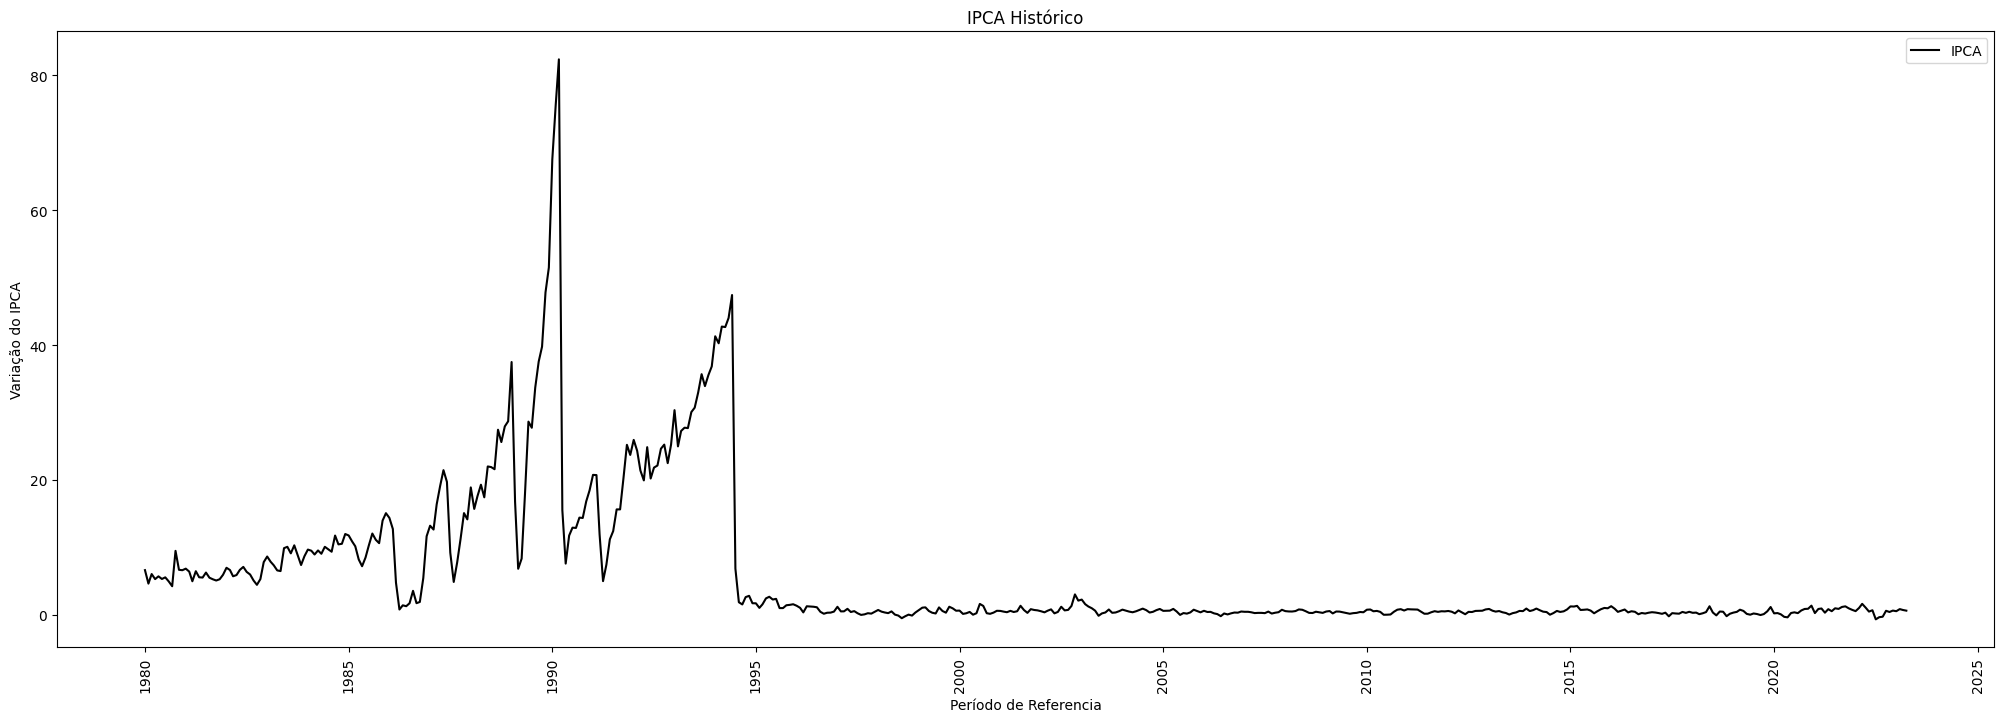

In [8]:
plt.figure(figsize=(25, 8))
plt.plot(df_ipca, label="IPCA", color='black')

plt.xlabel("Período de Referencia")
plt.ylabel("Variação do IPCA")

plt.xticks(rotation=90)

plt.title("IPCA Histórico")
plt.legend()
plt.show()

* Como foi detecatada uma grande taxa de inflação nos anos anteriores a 1995, vamos diminuir o range para datas maiores que esse ano

In [9]:
df_ipca = df_ipca[df_ipca.index >= "2005-01-01"]

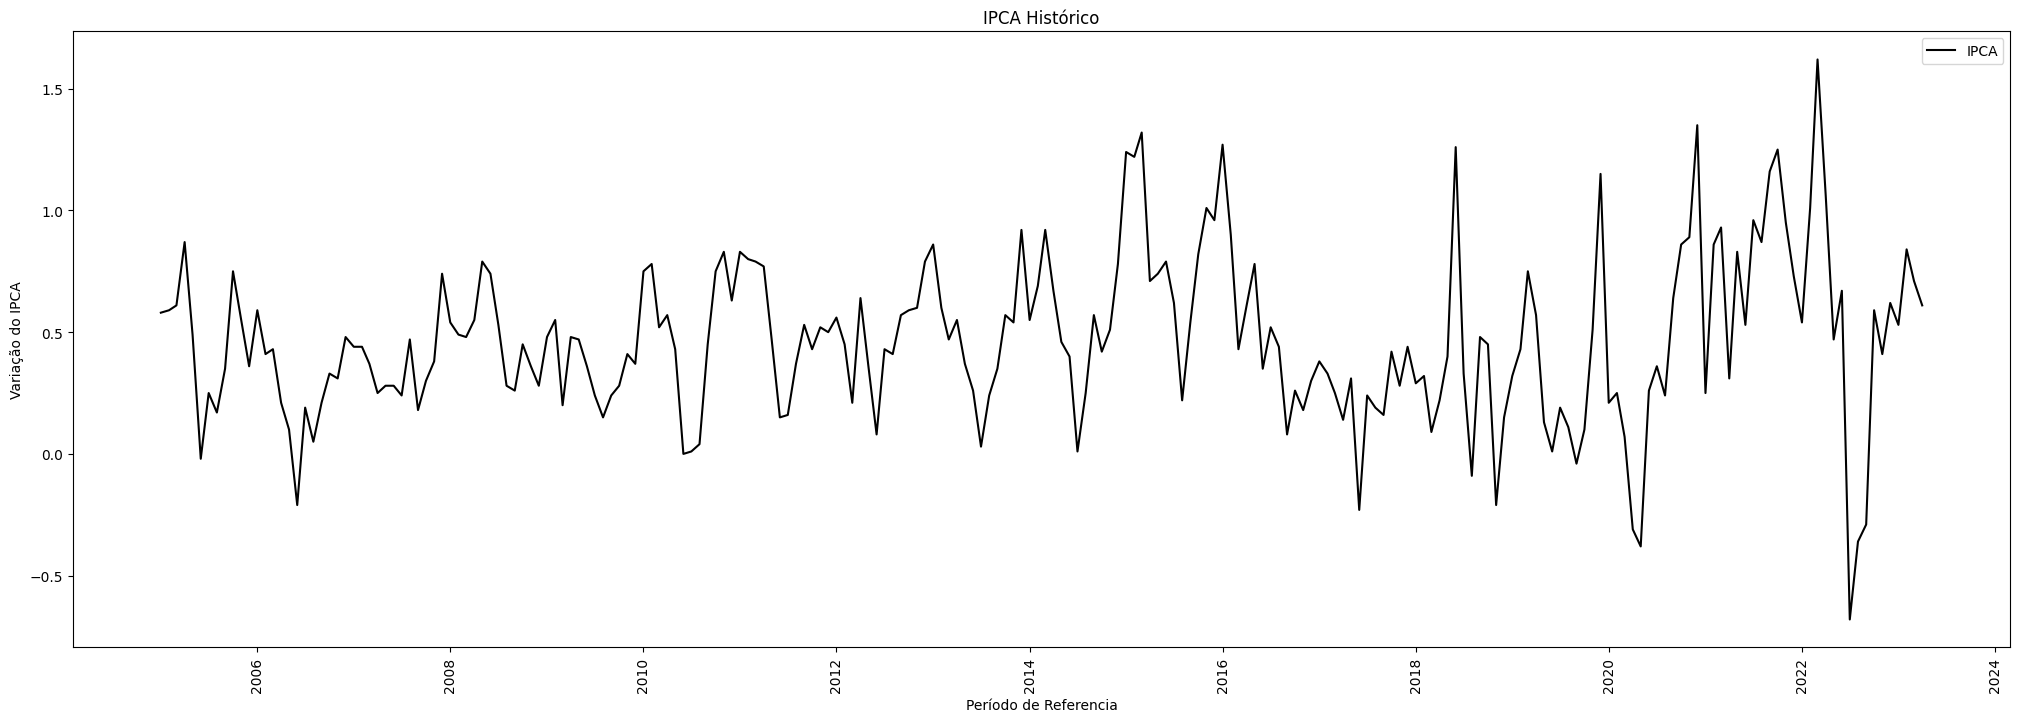

In [10]:
plt.figure(figsize=(25, 8))
plt.plot(df_ipca, label="IPCA", color='black')

plt.xlabel("Período de Referencia")
plt.ylabel("Variação do IPCA")

plt.xticks(rotation=90)

plt.title("IPCA Histórico")
plt.legend()
plt.show()

### Verificando se a série é estacionária

In [62]:
result = adfuller(df_ipca.ipca_acumulado_ano)

In [63]:
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -7.507758218788566
p-value: 4.091592752720212e-11
Critical Values:
	1%: -3.460567372610299
	5%: -2.874829809033386
	10%: -2.573853225954421


* A estatística ADF está próximo dos valores críticos e o p-valor é menor que o limite (0,05). 
* Assim, podemos concluir que a série temporal é estacionária.

### Distribuição da variação do IPCA

In [11]:
df_ipca.ipca_acumulado_ano.mean()

0.4650909090909091

In [12]:
df_ipca.ipca_acumulado_ano.std()

0.3360059399739831

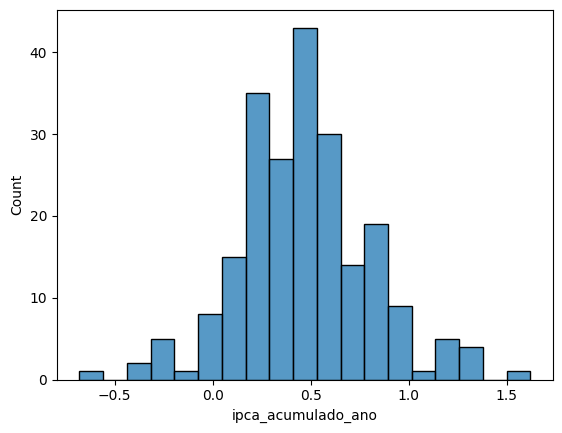

In [61]:
sns.histplot(df_ipca.ipca_acumulado_ano);

# Split de Treino e Teste

In [14]:
train = df_ipca[df_ipca.index <= "2021-01-01"]

In [15]:
test = df_ipca[df_ipca.index >= "2021-01-01"]

In [16]:
train.shape

(193, 1)

In [17]:
test.shape

(28, 1)

### Avaliação de Treino e Teste

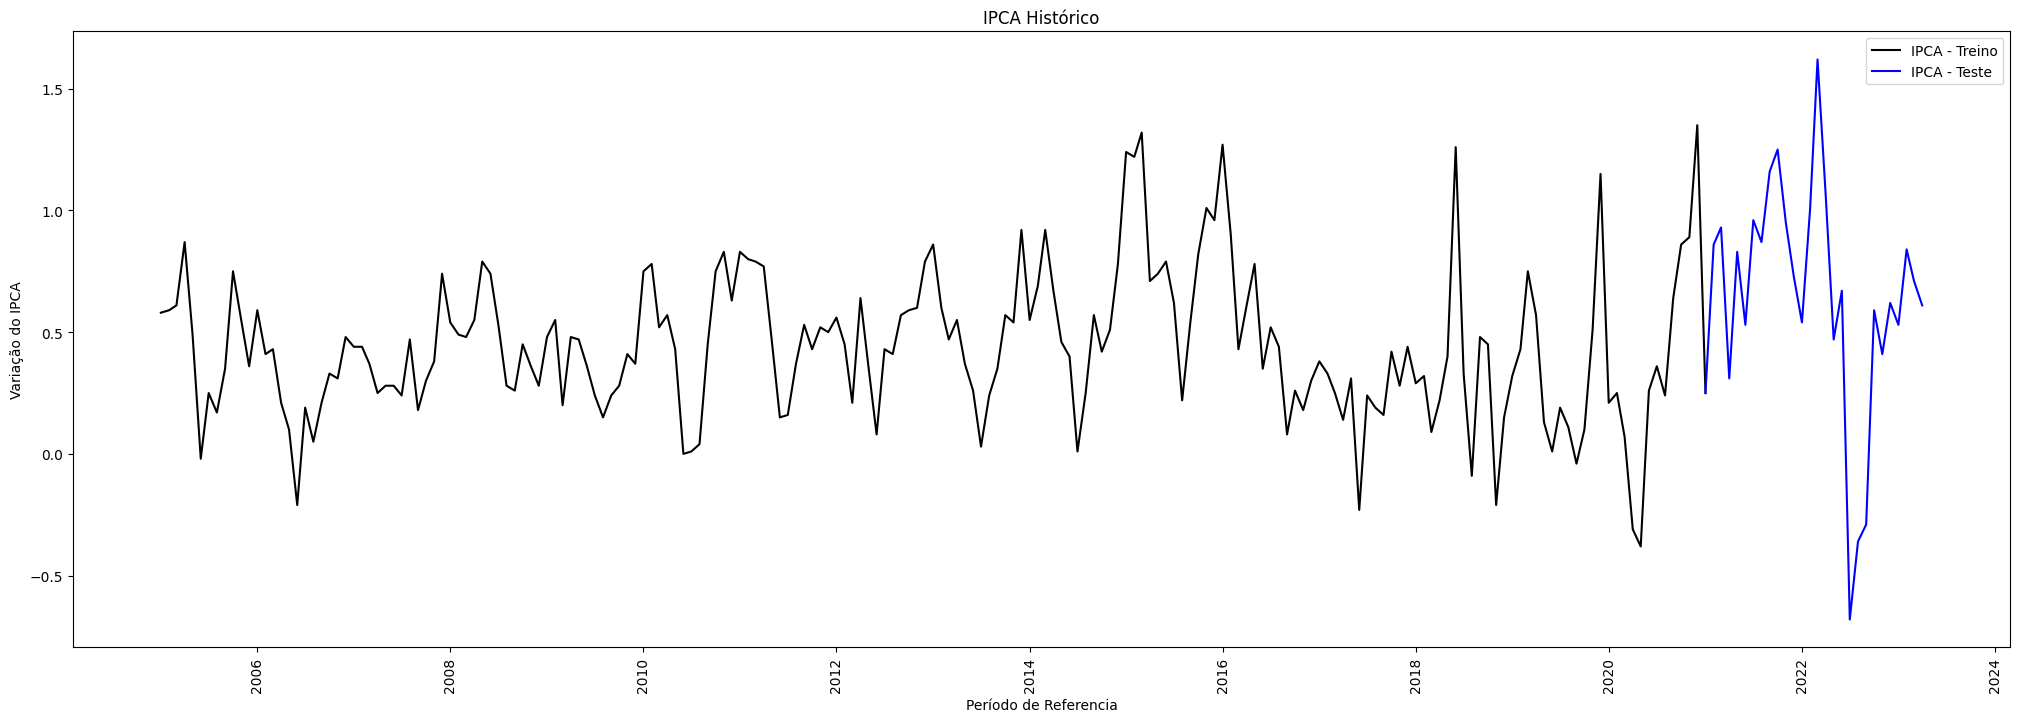

In [18]:
plt.figure(figsize=(25, 8))
plt.plot(train, label="IPCA - Treino", color='black')
plt.plot(test, label="IPCA - Teste", color='blue')
plt.xlabel("Período de Referencia")
plt.ylabel("Variação do IPCA")

plt.xticks(rotation=90)

plt.title("IPCA Histórico")
plt.legend()
plt.show()

# Modelo de Suavização Exponencial
* O método de suavização exponencial é uma técnica de previsão usada para estimar valores futuros com base em padrões passados. Ele é amplamente utilizado em análise de séries temporais e é particularmente útil quando há uma tendência ou padrão subjacente nos dados.
* A ideia principal por trás da suavização exponencial é atribuir pesos decrescentes aos pontos de dados anteriores à medida que avançamos no tempo. 
* O método assume que os valores mais recentes têm mais relevância para a previsão do que os valores mais antigos. Isso é alcançado por meio de uma média ponderada dos pontos de dados anteriores, com os pesos atribuídos exponencialmente diminuindo à medida que nos afastamos no tempo.

* Lembre-se de adaptar esse código de acordo com a estrutura dos seus dados. É importante verificar se a série temporal possui tendência e sazonalidade e ajustar os parâmetros `trend` e `seasonal` adequadamente.

## Parâmetros Importantes

### trend

O parâmetro `trend` no Exponential Smoothing permite especificar o tipo de tendência a ser considerada no modelo. Ele possui as seguintes opções:

1. `add` ou `additive`: Essa opção considera uma tendência aditiva, em que o efeito da tendência é adicionado linearmente aos valores observados. **É adequada quando a magnitude da tendência é constante ao longo do tempo**.

2. `mul` ou `multiplicative`: Essa opção considera uma tendência multiplicativa, em que o efeito da tendência é multiplicado aos valores observados. **É adequada quando a magnitude da tendência aumenta ou diminui proporcionalmente ao longo do tempo**. - Só pode ser utilizada com valores positivos

3. `None`: Sem tendência

### Seasonal

O parâmetro `seasonal` no Exponential Smoothing permite especificar a presença de sazonalidade na série temporal. Ele possui as seguintes opções:

1. None: Essa opção indica a ausência de sazonalidade na série temporal. É adequada quando não há um padrão sazonal identificável nos dados.

2. 'add' ou 'additive': Essa opção considera uma sazonalidade aditiva, em que o efeito sazonal é adicionado linearmente aos valores observados. É adequada quando a magnitude da sazonalidade é constante ao longo do tempo.

3. 'mul' ou 'multiplicative': Essa opção considera uma sazonalidade multiplicativa, em que o efeito sazonal é multiplicado aos valores observados. É adequada quando a magnitude da sazonalidade aumenta ou diminui proporcionalmente ao longo do tempo.

Junto dele, temos que informar o `seasonal_periods`

Por exemplo, ao criar o modelo de Exponential Smoothing, você pode especificar a presença de sazonalidade usando o parâmetro seasonal da seguinte maneira:

```python
model = sm.tsa.ExponentialSmoothing(data['valor'], seasonal="add", seasonal_periods=12)
```

e você tiver uma série temporal com frequência mensal, é possível ajustar o Exponential Smoothing levando em consideração a sazonalidade mensal. Nesse caso, você pode especificar o período de sazonalidade como 12, indicando que há um padrão sazonal repetitivo a cada 12 meses.

Aqui está um exemplo de como ajustar o Exponential Smoothing com sazonalidade mensal usando a biblioteca StatsModels:

```python
model = sm.tsa.ExponentialSmoothing(data['valor'], seasonal="add",  seasonal_periods=12)
```

In [19]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [20]:
# Definir os parâmetros do modelo de suavização exponencial
alpha = 0.2  # Parâmetro de suavização

In [21]:
model = ExponentialSmoothing(
    train['ipca_acumulado_ano'], 
    trend="add", 
    seasonal="add", seasonal_periods=12,
    freq=train.index.inferred_freq,
    damped_trend=True
).fit(
    smoothing_level=alpha
)

In [22]:
forecast_exp_smoothing = model.forecast(test.shape[0])

In [23]:
forecast_exp_smoothing

2021-02-01    0.674579
2021-03-01    0.591707
2021-04-01    0.566559
2021-05-01    0.485632
2021-06-01    0.378388
2021-07-01    0.370168
2021-08-01    0.319392
2021-09-01    0.446146
2021-10-01    0.583932
2021-11-01    0.576720
2021-12-01    0.734268
2022-01-01    0.686286
2022-02-01    0.674579
2022-03-01    0.591707
2022-04-01    0.566559
2022-05-01    0.485632
2022-06-01    0.378388
2022-07-01    0.370168
2022-08-01    0.319392
2022-09-01    0.446146
2022-10-01    0.583932
2022-11-01    0.576720
2022-12-01    0.734268
2023-01-01    0.686286
2023-02-01    0.674579
2023-03-01    0.591707
2023-04-01    0.566559
2023-05-01    0.485632
Freq: MS, dtype: float64

In [24]:
rmse_exp_smoothing = np.sqrt(mean_squared_error(test, forecast_exp_smoothing))

In [25]:
rmse_exp_smoothing

0.47958563049273095

# Modelo de Suavização Simples

O alisamento exponencial simples é um método básico que considera apenas o nível da série temporal, assumindo que não há tendência ou sazonalidade. Ele atribui pesos decrescentes exponencialmente aos valores passados e faz uma média ponderada para obter a previsão. É adequado para séries temporais que não apresentam tendência ou sazonalidade.

## Parâmetros Importantes

### initialization_method

O parâmetro `initialization_method` possui as seguintes opções:

1. `estimated` (padrão): Nessa opção, os valores iniciais dos parâmetros são estimados automaticamente pelo modelo com base em uma heurística interna. Essa é a opção recomendada em muitos casos, pois o modelo tentará encontrar automaticamente valores iniciais razoáveis para os parâmetros.

2. `heuristic`: Nessa opção, os valores iniciais dos parâmetros são definidos usando heurísticas específicas. Isso pode ser útil quando você deseja fornecer valores iniciais personalizados para os parâmetros com base em seu conhecimento prévio da série temporal.

3. `legacy-heuristic`: Essa opção usa um conjunto diferente de heurísticas para definir os valores iniciais dos parâmetros. É uma opção legada e menos recomendada em comparação com as outras opções.

O valor padrão `estimated` é geralmente uma escolha segura, pois permite que o modelo encontre automaticamente os valores iniciais adequados. No entanto, em casos específicos, como quando você tem um conhecimento prévio sobre os parâmetros, você pode optar por usar um método de inicialização personalizado.

In [26]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [27]:
model_simple = SimpleExpSmoothing(
    train['ipca_acumulado_ano'],
    initialization_method="estimated"
)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [28]:
fitted_simple = model_simple.fit()

In [29]:
fitted_simple.params

{'smoothing_level': 0.6785774458758129,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 0.5884144076104759,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [30]:
forecast_simple = fitted_simple.predict(start=len(train), end=len(train) + len(test)-1)

In [31]:
forecast_simple

2021-02-01    0.551356
2021-03-01    0.551356
2021-04-01    0.551356
2021-05-01    0.551356
2021-06-01    0.551356
2021-07-01    0.551356
2021-08-01    0.551356
2021-09-01    0.551356
2021-10-01    0.551356
2021-11-01    0.551356
2021-12-01    0.551356
2022-01-01    0.551356
2022-02-01    0.551356
2022-03-01    0.551356
2022-04-01    0.551356
2022-05-01    0.551356
2022-06-01    0.551356
2022-07-01    0.551356
2022-08-01    0.551356
2022-09-01    0.551356
2022-10-01    0.551356
2022-11-01    0.551356
2022-12-01    0.551356
2023-01-01    0.551356
2023-02-01    0.551356
2023-03-01    0.551356
2023-04-01    0.551356
2023-05-01    0.551356
Freq: MS, dtype: float64

In [32]:
rmse_simple = np.sqrt(mean_squared_error(test, forecast_simple))

In [33]:
rmse_simple

0.4858296586542974

# Modelo de Holt

O modelo de Holt, também conhecido como **Holts Linear Exponential Smoothing**, é um método de previsão utilizado em análise de séries temporais. Ele é uma extensão do alisamento exponencial simples que leva em consideração tanto o nível (ou nível médio) quanto a tendência da série temporal.

**O modelo de Holt é útil quando os dados apresentam uma tendência linear, ou seja, uma mudança constante na média ao longo do tempo. Ele assume que o nível da série (nível médio) e a tendência são funções lineares do tempo**

O modelo de Holt utiliza dois fatores de suavização, um para o nível (smoothing level) e outro para a tendência (smoothing slope), para calcular as previsões. Os valores desses fatores de suavização são ajustados durante o processo de estimação do modelo.

Ao fazer previsões com o modelo de Holt, ele leva em consideração a atualização do nível e da tendência a cada período de tempo, resultando em projeções que seguem a tendência de forma linear.

In [34]:
from statsmodels.tsa.holtwinters import Holt

In [52]:
model_holt = Holt(
    train['ipca_acumulado_ano'],
    initialization_method="heuristic",
    exponential=False
)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [53]:
fitted_holt = model_holt.fit()

In [54]:
fitted_holt.params

{'smoothing_level': 0.6787378843588798,
 'smoothing_trend': 1.9353141753550799e-16,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 0.588703765096565,
 'initial_trend': -0.00022708638292052183,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [55]:
forecast_holt = fitted_holt.predict(start=len(train), end=len(train) + len(test)-1)

In [56]:
forecast_holt

2021-02-01    0.550902
2021-03-01    0.550675
2021-04-01    0.550448
2021-05-01    0.550221
2021-06-01    0.549994
2021-07-01    0.549767
2021-08-01    0.549540
2021-09-01    0.549313
2021-10-01    0.549086
2021-11-01    0.548859
2021-12-01    0.548631
2022-01-01    0.548404
2022-02-01    0.548177
2022-03-01    0.547950
2022-04-01    0.547723
2022-05-01    0.547496
2022-06-01    0.547269
2022-07-01    0.547042
2022-08-01    0.546815
2022-09-01    0.546588
2022-10-01    0.546361
2022-11-01    0.546133
2022-12-01    0.545906
2023-01-01    0.545679
2023-02-01    0.545452
2023-03-01    0.545225
2023-04-01    0.544998
2023-05-01    0.544771
Freq: MS, dtype: float64

In [57]:
rmse_holt = np.sqrt(mean_squared_error(test, forecast_holt))

In [58]:
rmse_holt

0.48605849220995123

# Arima / Sarima - Autoarima

In [89]:
# sarima_model = auto_arima(train, start_p=1, start_q=1,
#                       test='adf',       # use adftest to find optimal 'd'
#                       max_p=8, max_q=8, max_d=8, # maximum p, q and d
#                       m=12,              # frequency of series
#                       d=1,              # let model determine 'd'
#                       seasonal=True,   #  Seasonality
#                       start_P=0, 
#                       D=0, 
#                       trace=True,
#                       error_action='ignore',  
#                       suppress_warnings=True, 
#                       stepwise=True)

In [112]:
sarima_model = auto_arima(train, start_p=0, start_q=0, 
                          start_P=0, start_Q=0, 
                          start_D=0, max_p=8, max_q=8, max_P=8, max_Q=8, max_D=8, 
                          d=1,
                          seasonal=True,
                          stepwise=True, 
                          suppress_warnings=True,
                          error_action='ignore', 
                          m=12, trace=True, jobs=-1
                         )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=54.220, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=49.176, Time=0.31 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=43.842, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=52.228, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=45.529, Time=0.03 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=41.189, Time=0.33 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=43.556, Time=0.11 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=42.981, Time=0.82 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=42.943, Time=1.54 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=45.518, Time=0.78 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=45.337, Time=0.23 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=1.79 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=55.070, Time=0.12 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,1,2)(1,0,1)[12] intercept   : AIC=19.188, Ti

In [113]:
forecast_arima = sarima_model.predict(n_periods=len(test.index))

In [114]:
forecast_arima

2021-02-01    0.217996
2021-03-01    0.434566
2021-04-01    0.379715
2021-05-01    0.339976
2021-06-01    0.363128
2021-07-01    0.343221
2021-08-01    0.289124
2021-09-01    0.376546
2021-10-01    0.455264
2021-11-01    0.447776
2021-12-01    0.601925
2022-01-01    0.462024
2022-02-01    0.447712
2022-03-01    0.432756
2022-04-01    0.381498
2022-05-01    0.344361
2022-06-01    0.365998
2022-07-01    0.347394
2022-08-01    0.296840
2022-09-01    0.378537
2022-10-01    0.452099
2022-11-01    0.445101
2022-12-01    0.589154
2023-01-01    0.458416
2023-02-01    0.445041
2023-03-01    0.431065
2023-04-01    0.383164
2023-05-01    0.348460
Freq: MS, dtype: float64

In [115]:
rmse_arima = np.sqrt(mean_squared_error(test, forecast_arima))

In [116]:
rmse_arima

0.526009974287496

# Visualização dos Modelos

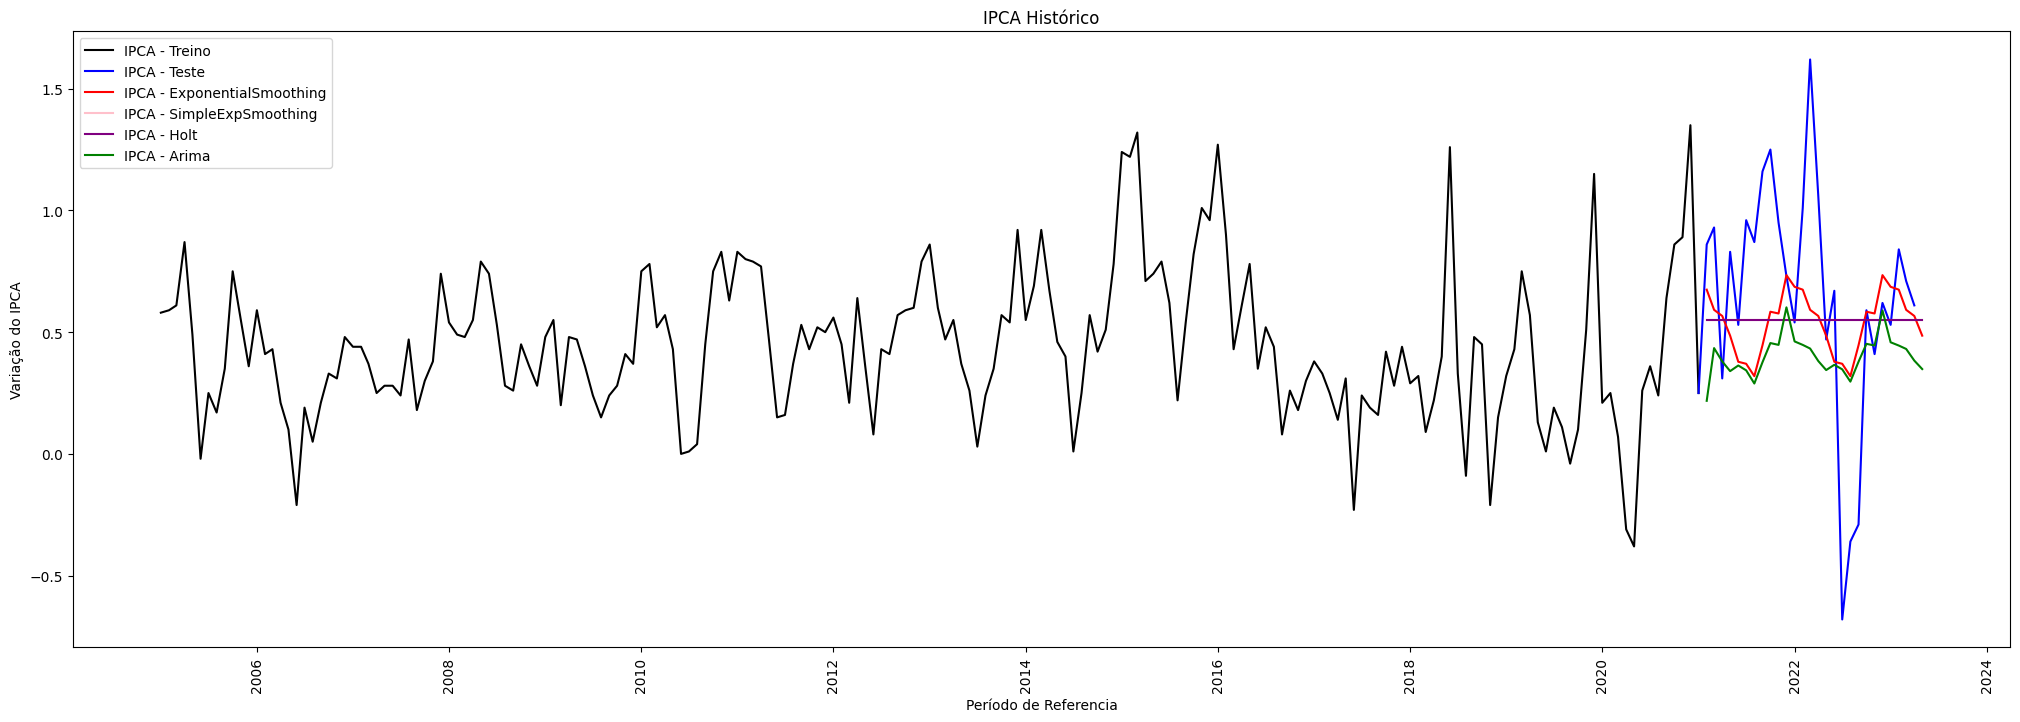

In [117]:
plt.figure(figsize=(25, 8))
plt.plot(train, label="IPCA - Treino", color='black')
plt.plot(test, label="IPCA - Teste", color='blue')
plt.plot(forecast_exp_smoothing, label="IPCA - ExponentialSmoothing", color='red')
plt.plot(forecast_simple, label="IPCA - SimpleExpSmoothing", color='pink')
plt.plot(forecast_simple, label="IPCA - Holt", color='purple')
plt.plot(forecast_arima, label="IPCA - Arima", color='green')
plt.xlabel("Período de Referencia")
plt.ylabel("Variação do IPCA")

plt.xticks(rotation=90)

plt.title("IPCA Histórico")
plt.legend()
plt.show()

In [118]:
print("RMSE")
print(f'ExponencialSmoothing: {rmse_exp_smoothing}')
print(f'SimpleExpSmoothing: {rmse_simple}')
print(f'Holt: {rmse_holt}')
print(f'Arima: {rmse_arima}')

RMSE
ExponencialSmoothing: 0.47958563049273095
SimpleExpSmoothing: 0.4858296586542974
Holt: 0.48605849220995123
Arima: 0.526009974287496
